# **Digits Detection of License Plate Number**
In this notebook we will build tensorflow model to recognize each digits of a license plate number. We will use **Tensorflow Object Detection API** and **Mask R-CNN Inception ResNet V2 1024x1024**.

Here is step by step building digits detection model.

# 0. Setup Paths

In [3]:
import os

In [4]:
CUSTOM_MODEL_NAME = 'my_ssd_resnet50_v1_fpn' 
PRETRAINED_MODEL_NAME = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [5]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [6]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [7]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [8]:
if os.name=='nt':
    !pip install wget
    import wget

In [9]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 56740, done.
remote: Counting objects: 100% (927/927), done.
remote: Compressing objects: 100% (405/405), done.
remote: Total 56740 (delta 578), reused 819 (delta 507), pack-reused 55813
Receiving objects: 100% (56740/56740), 572.77 MiB | 35.33 MiB/s, done.
Resolving deltas: 100% (39149/39149), done.


In [10]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Processing /content/Tensorflow/models/research
     |████████████████████████████████| 9.6MB 19.9MB/s 
     |████████████████████████████████| 358kB 49.3MB/s 
     |████████████████████████████████| 1.1MB 45.1MB/s 
     |████████████████████████████████| 2.3MB 40.6MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 153kB 57.6MB/s 
     |████████████████████████████████| 829kB 27.8MB/s 
     |████████████████████████████████| 686kB 40.8MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 174kB 49.7MB/s 
     |██████████████████████████

Don't worry if you see some error while installing some dependencies for Tensorflow Object Detection. It doesn't mean you failed to install Tensorflow Object Detection. 

You will verify the installation with codes below. If it say "OK" at the end, then you are successfully install Tensorflow Object Detection :)

In [11]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2021-05-18 01:11:15.840662: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-05-18 01:11:18.283290: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-18 01:11:18.284336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-18 01:11:18.352117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-18 01:11:18.352721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB de

In [12]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2021-05-18 01:12:08--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.164.144, 2607:f8b0:4004:814::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.164.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   133MB/s    in 1.8s    

2021-05-18 01:12:10 (133 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_res

# 2. Create Label Map

In [13]:
import string

labels = []
i = 1
for char in string.ascii_uppercase:
  tmp = {'name': char, 'id': i}
  labels.append(tmp)
  i += 1

for num in range(0,10):
  tmp = {'name': str(num), 'id': i}
  labels.append(tmp)
  i += 1

print(labels)

[{'name': 'A', 'id': 1}, {'name': 'B', 'id': 2}, {'name': 'C', 'id': 3}, {'name': 'D', 'id': 4}, {'name': 'E', 'id': 5}, {'name': 'F', 'id': 6}, {'name': 'G', 'id': 7}, {'name': 'H', 'id': 8}, {'name': 'I', 'id': 9}, {'name': 'J', 'id': 10}, {'name': 'K', 'id': 11}, {'name': 'L', 'id': 12}, {'name': 'M', 'id': 13}, {'name': 'N', 'id': 14}, {'name': 'O', 'id': 15}, {'name': 'P', 'id': 16}, {'name': 'Q', 'id': 17}, {'name': 'R', 'id': 18}, {'name': 'S', 'id': 19}, {'name': 'T', 'id': 20}, {'name': 'U', 'id': 21}, {'name': 'V', 'id': 22}, {'name': 'W', 'id': 23}, {'name': 'X', 'id': 24}, {'name': 'Y', 'id': 25}, {'name': 'Z', 'id': 26}, {'name': '0', 'id': 27}, {'name': '1', 'id': 28}, {'name': '2', 'id': 29}, {'name': '3', 'id': 30}, {'name': '4', 'id': 31}, {'name': '5', 'id': 32}, {'name': '6', 'id': 33}, {'name': '7', 'id': 34}, {'name': '8', 'id': 35}, {'name': '9', 'id': 36}]


In [14]:
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

You can download the license plate dataset [here](https://drive.google.com/file/d/1NYhjCG4BUJeZlRKI2cO1x-Fd9iPiv0-v/view?usp=sharing). Then upload it to `Tensorflow/workspace/images/`.



In [15]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

Tensorflow/workspace/images/train/
Tensorflow/workspace/images/train/1.E 3977 QM-09-19.jpeg
Tensorflow/workspace/images/train/1.E 3977 QM-09-19.xml
Tensorflow/workspace/images/train/10.E 5894 SZ-09-17.jpg
Tensorflow/workspace/images/train/10.E 5894 SZ-09-17.xml
Tensorflow/workspace/images/train/11.E 6562 QO-12-19.jpeg
Tensorflow/workspace/images/train/11.E 6562 QO-12-19.xml
Tensorflow/workspace/images/train/12.E 2462 QF-02-19.jpeg
Tensorflow/workspace/images/train/12.E 2462 QF-02-19.xml
Tensorflow/workspace/images/train/13.E 5313 TF-10-16.jpeg
Tensorflow/workspace/images/train/13.E 5313 TF-10-16.xml
Tensorflow/workspace/images/train/14.E 1129 RP-07-18.jpg
Tensorflow/workspace/images/train/14.E 1129 RP-07-18.xml
Tensorflow/workspace/images/train/17.E 4172 QC-11-18.jpg
Tensorflow/workspace/images/train/17.E 4172 QC-11-18.xml
Tensorflow/workspace/images/train/18.E 3865 PAF-08-21.jpeg
Tensorflow/workspace/images/train/18.E 3865 PAF-08-21.xml
Tensorflow/workspace/images/train/19.E 6179 SH-0

In [16]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [17]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

In [18]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [19]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [20]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [21]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.99699997901

In [22]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [23]:
len(labels)

36

In [25]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 8
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_config.use_bfloat16 = False
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [26]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [29]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [30]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [31]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn --pipeline_config_path=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn/pipeline.config --num_train_steps=2000


In [32]:
!{command}

2021-05-18 01:21:54.686938: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-18 01:21:57.031972: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-18 01:21:57.032988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-18 01:21:57.064938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-18 01:21:57.065552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-05-18 01:21:57.065588: I tensorflow/stream_executor/platform/default/dso_loade

# 7. Evaluate the Model

In [33]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [34]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn --pipeline_config_path=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn


In [35]:
!{command}

2021-05-18 02:03:58.994686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
W0518 02:04:01.509006 140046209570688 model_lib_v2.py:1064] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0518 02:04:01.509249 140046209570688 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0518 02:04:01.509355 140046209570688 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0518 02:04:01.509449 140046209570688 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0518 02:04:01.509577 140046209570688 model_lib_v2.py:1085] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2021-05-18 02:04:01.517497: I tensorflow/compiler/jit/xla

# 8. Load Train Model From Checkpoint

In [49]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [50]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [51]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [52]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [64]:
print(category_index)

{1: {'id': 1, 'name': 'A'}, 2: {'id': 2, 'name': 'B'}, 3: {'id': 3, 'name': 'C'}, 4: {'id': 4, 'name': 'D'}, 5: {'id': 5, 'name': 'E'}, 6: {'id': 6, 'name': 'F'}, 7: {'id': 7, 'name': 'G'}, 8: {'id': 8, 'name': 'H'}, 9: {'id': 9, 'name': 'I'}, 10: {'id': 10, 'name': 'J'}, 11: {'id': 11, 'name': 'K'}, 12: {'id': 12, 'name': 'L'}, 13: {'id': 13, 'name': 'M'}, 14: {'id': 14, 'name': 'N'}, 15: {'id': 15, 'name': 'O'}, 16: {'id': 16, 'name': 'P'}, 17: {'id': 17, 'name': 'Q'}, 18: {'id': 18, 'name': 'R'}, 19: {'id': 19, 'name': 'S'}, 20: {'id': 20, 'name': 'T'}, 21: {'id': 21, 'name': 'U'}, 22: {'id': 22, 'name': 'V'}, 23: {'id': 23, 'name': 'W'}, 24: {'id': 24, 'name': 'X'}, 25: {'id': 25, 'name': 'Y'}, 26: {'id': 26, 'name': 'Z'}, 27: {'id': 27, 'name': '0'}, 28: {'id': 28, 'name': '1'}, 29: {'id': 29, 'name': '2'}, 30: {'id': 30, 'name': '3'}, 31: {'id': 31, 'name': '4'}, 32: {'id': 32, 'name': '5'}, 33: {'id': 33, 'name': '6'}, 34: {'id': 34, 'name': '7'}, 35: {'id': 35, 'name': '8'}, 36

In [53]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '351.E 6730 RC-07-19.jpeg')

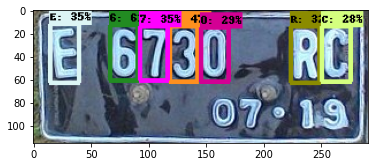

In [71]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# print hasil deteksi

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=8,
            min_score_thresh=0.27,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [81]:
boxes = detections['detection_boxes']
max_boxes_to_draw = 8
scores = detections['detection_scores']
class_idx = detections['detection_classes']+label_id_offset
min_score_thresh=.27

result = []
for i in range(min(max_boxes_to_draw, boxes.shape[0])):
  if scores[i] > min_score_thresh:
    item = {"label": category_index[class_idx[i]]["name"],
            "score": scores[i],
            "boxes": boxes[i][1]
    }
    result.append(item)

result = sorted(result, key=lambda k: k['boxes'])

[{'label': 'E', 'score': 0.34517783, 'boxes': 0.050864}, {'label': '6', 'score': 0.61011606, 'boxes': 0.22993813}, {'label': '7', 'score': 0.34821776, 'boxes': 0.31829262}, {'label': '3', 'score': 0.46756694, 'boxes': 0.40702415}, {'label': '0', 'score': 0.28962407, 'boxes': 0.4999835}, {'label': 'R', 'score': 0.32339206, 'boxes': 0.76706034}, {'label': 'C', 'score': 0.27881187, 'boxes': 0.8620933}]


# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [ ]:
!{command}

2021-04-03 11:51:42.281339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:51:44.712115: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:51:44.712813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:51:44.734951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:51:44.734976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:51:44.738520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

  Using cached tensorflowjs-3.3.0-py3-none-any.whl (63 kB)
  Using cached tensorflow_hub-0.9.0-py2.py3-none-any.whl (103 kB)
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport


In [ ]:
!{command}

Writing weight file Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport\model.json...


2021-04-03 11:54:23.153051: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:54:25.644887: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:54:25.645576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:54:25.667969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:54:25.668001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:54:25.671400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport


In [ ]:
!{command}

2021-04-03 11:55:05.530772: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:08.004889: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:55:08.005672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:55:08.028532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:55:08.028559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:08.032092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

2021-04-03 11:55:14.884114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2021-04-03 11:55:14.884117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2021-04-03 11:55:14.884182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6611 MB memory) -> physical GPU (device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:2b:00.0, compute capability: 7.5)
2021-04-03 11:55:14.884197: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
W0403 11:55:15.360029 15552 save_impl.py:78] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x00000224AC2B1908>, because it is not built.
W0403 11:55:15.925411 15552 save_impl.py:78] Skipping full serialization of Keras layer <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x00000224D6D42B00>, bec

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [ ]:
!{command}

2021-04-03 11:55:38.653963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:41.159460: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:55:41.160164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:55:41.183623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:55:41.183649: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:41.187402: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')